In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../..'))

from PySDM.physics import si
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity
from PySDM.initialisation.spectra import Gamma
from PySDM.physics.formulae import volume

/home/edejong/.conda/envs/edjPySDM/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


# 1. Golovin Kernel: dimensionless quantities

98304.0
61065.0
37848.0
23393.0
14403.0
8983.0
5488.0
3381.0
2109.0
1362.0


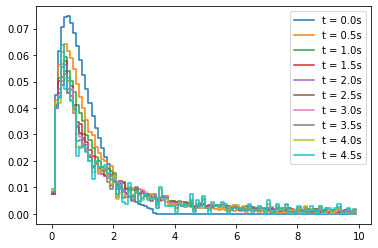

In [43]:
# Set desired constants
dt_sim = 1e-2          # time step
T_sim  = 5             # total time of simulation
n_sd   = 2**14         # number of superdroplets
N0     = 1e5           # total number of droplets
K      = 1/N0          # Kernel constant
end_step = int(T_sim / dt_sim)
k = 2
theta = 0.5
kde_fac = 0.01

# initial distribution
initial_spectrum = Gamma(norm_factor=N0, k=k, theta=theta)
attributes = {}
attributes['volume'], attributes['n'] =\
    ConstantMultiplicity(spectrum=initial_spectrum).sample(n_sd)

from PySDM import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics.coalescence.kernels import Golovin
from PySDM.backends import CPU
from PySDM.products.state import ParticlesVolumeSpectrum, ParticlesNumberVolumeSpectrum, KthMoment

builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=dt_sim, dv=1))
builder.add_dynamic(Coalescence(kernel=Golovin(b = K)))
products = [ParticlesVolumeSpectrum(), ParticlesNumberVolumeSpectrum(), KthMoment()]
particles = builder.build(attributes, products)

from matplotlib import pyplot
import numpy as np

Nbins = 101
v_bins_edges = np.linspace((0), (10), num=Nbins)
track_steps = np.linspace((0), (T_sim), num=end_step)
time_series_by_bin = np.zeros((end_step, Nbins-1))

for step in range(0, end_step):
    particles.run(step - particles.n_steps)
    time_series_by_bin[step,:] = particles.products['N(v)'].get(v_bins_edges)/particles.products['Mk'].get(0)
    if ((step%int(end_step/10)) == 0):
        pyplot.step(x=v_bins_edges[:-1],
                    y=particles.products['N(v)'].get(v_bins_edges)/particles.products['Mk'].get(0),
                    where='post', label=f"t = {step*dt_sim}s")
        print(particles.products['Mk'].get(0))
    pyplot.legend()

In [40]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
filename='snapshots'+timestr+'.out'
topline = 'N0='+str(N0)+', K='+str(K)+', shape factor='+str(k)+', scale factor='+str(theta)+'\n'
topline = topline + 'timesteps: ' + str(track_steps)

np.savetxt(filename, time_series_by_bin, header=topline)

In [36]:
str(N0)

'100000.0'